In [1]:
import numpy as np
import pandas as pd
import rainflow
import matplotlib.pyplot as plt
import math

In [2]:
paths = {
    "Scenario 1": "results/scenario_1/EES_20240906T103246M908736/",
    "Scenario 2": "results/scenario_2/EES_20240906T103246M966851/",
    "Scenario 3": "results/scenario_3/EES_20240906T103247M060619/",
}

In [3]:
# path = "results/scenario_3/EES_20240906T103247M060619/"
# df = pd.read_csv(path + "LithiumIonState.csv.gz", engine="pyarrow")

In [4]:
df_lio = dict()
df_ems = dict()
df_sys = dict()
df_eff = dict()

for scenario, path in paths.items():
    # load data
    df_lio[scenario] = pd.read_csv(path + "LithiumIonState.csv.gz", engine="pyarrow")

    df_ems[scenario] = pd.read_csv(path + "EnergyManagementState.csv.gz", engine="pyarrow")

    df_sys[scenario] = pd.read_csv(path + "SystemState.csv.gz", engine="pyarrow").drop_duplicates(subset=["Time in s"])

    df_eff[scenario] = pd.read_csv(path + "SystemTechnicalEvaluation0.0.csv", header=None, engine="pyarrow")

In [5]:
# Function to extract C-rate from the LithiumIonState DataFrame
def exctract_crates(df):
    cell_capacity = 3.0 # Ah
    parallel_cells = 3094 # no. of parllel cell
    return df["Current in A"] / parallel_cells / cell_capacity

In [6]:
# Function to extract cycle ranges from SOC profile
def exctract_cycles(df):
    cycles = pd.DataFrame(
        rainflow.extract_cycles(df["SOC in p.u."]), 
        columns=["range", "mean", "count", "start", "end"]
    )
    return cycles["range"] * cycles["count"]

In [7]:
# Function to extract SOC profile from the LithiumIonState DataFrame
def extract_soc_profile(df):
    return df["SOC in p.u."]

In [8]:
# Function to extract efficiency from the LithiumIonTechnicalEvaluation1.1.csv DataFrame
def extract_efficiency(df):
    return df.iloc[0, 1]  # Extract efficiency from the first row, second column

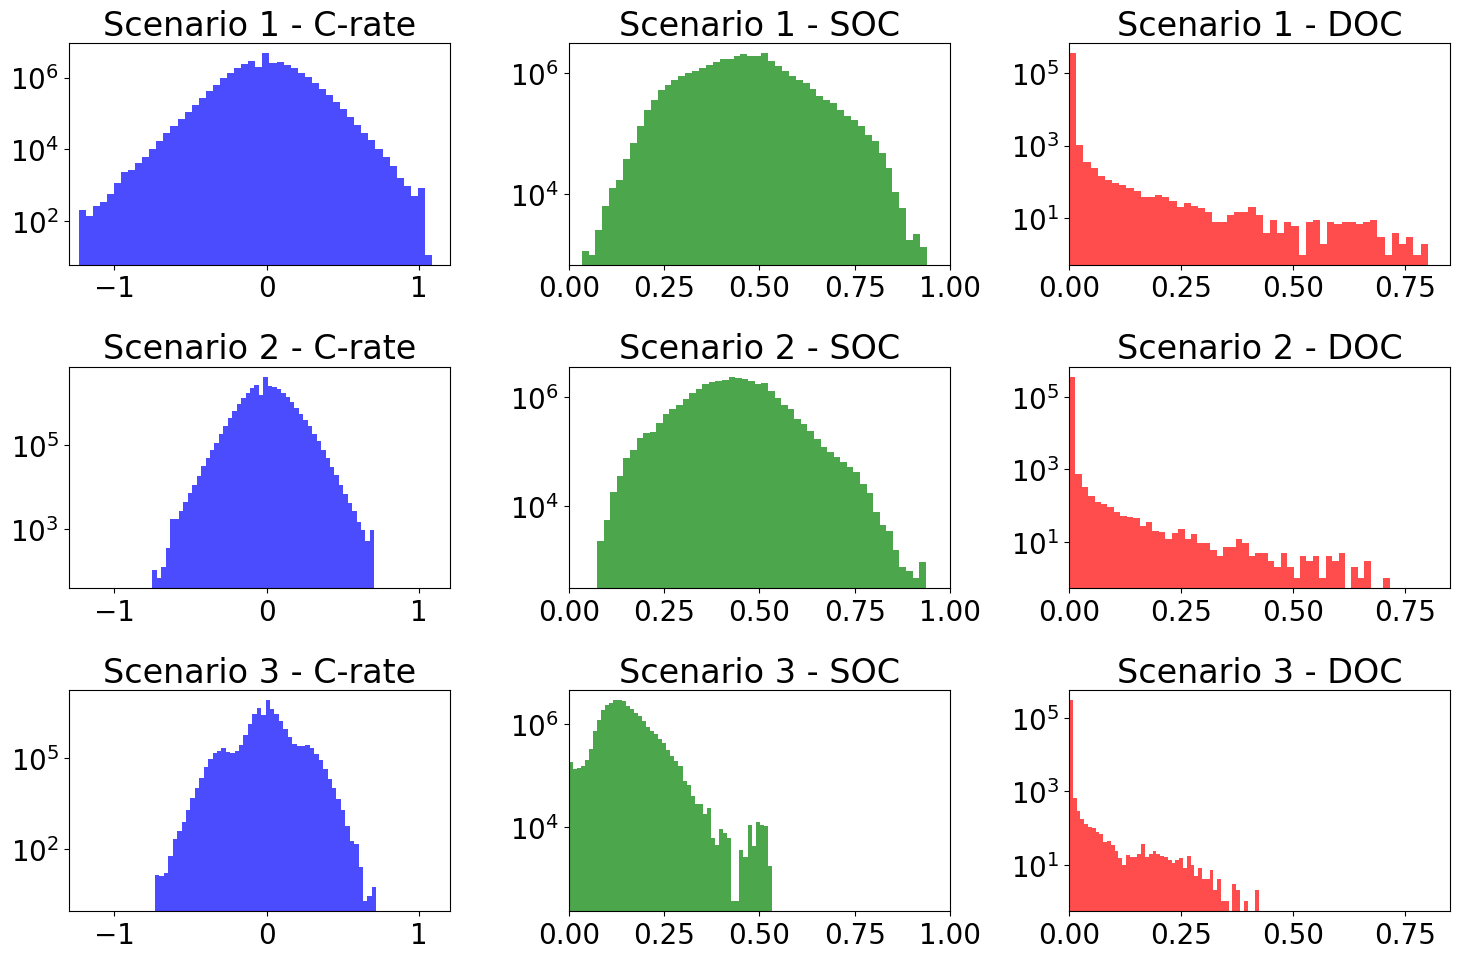

In [9]:
def plot_histograms(profiles):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

    # Set the font to Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 20

    for i, scenario in enumerate(profiles):
        profile = profiles[scenario]

        # Extract cycles, SOC, and C-rate
        cycles = exctract_cycles(profile)
        soc = extract_soc_profile(profile) # exctract soc profile from scenario
        crate = exctract_crates(profile) # extract crate from scenario

        # Plot histograms
        ax[i, 0].hist(crate, bins=50, color='blue', alpha=0.7)  # C-rate histogram
        ax[i, 0].set_title(f"{scenario} - C-rate")
        ax[i, 0].set_yscale('log')  # Set y-axis to log scale
        ax[i, 0].set_xlim(-1.3, 1.2)

        ax[i, 1].hist(soc, bins=50, color='green', alpha=0.7)  # SOC histogram
        ax[i, 1].set_title(f"{scenario} - SOC")
        ax[i, 1].set_yscale('log')  # Set y-axis to log scale
        ax[i, 1].set_xlim(0, 1)

        ax[i, 2].hist(cycles, bins=50, color='red', alpha=0.7)  # DOC histogram
        ax[i, 2].set_title(f"{scenario} - DOC")
        ax[i, 2].set_yscale('log')  # Set y-axis to log scale
        ax[i, 2].set_xlim(0, 0.85)

        # Adjust tick parameters
        for axis in ax[i]:
            axis.tick_params(axis='both', which='major', labelsize=20)

    plt.tight_layout()
    # plt.show()
    return fig

# Example usage
fig = plot_histograms(df_lio)

In [10]:
fig.savefig("figs/hist.pdf")
fig.savefig("figs/hist.svg")
fig.savefig("figs/hist.png")

In [11]:
# Extract and print efficiency for each scenario
for scenario in df_eff:
    efficiency = extract_efficiency(df_eff[scenario])
    print(f"Efficiency round trip for {scenario}: {efficiency:.2f}%")

Efficiency round trip for Scenario 1: 88.57%
Efficiency round trip for Scenario 2: 85.55%
Efficiency round trip for Scenario 3: 80.42%


In [12]:
# Extract the last value of SOH for each scenario
soh_scenario_1 = df_lio["Scenario 1"]["State of health in p.u."].iloc[-1]
soh_scenario_2 = df_lio["Scenario 2"]["State of health in p.u."].iloc[-1]
soh_scenario_3 = df_lio["Scenario 3"]["State of health in p.u."].iloc[-1]

# Print the extracted SOH values
print(f"Last SOH value for scenario_1: {soh_scenario_1}")
print(f"Last SOH value for scenario_2: {soh_scenario_2}")
print(f"Last SOH value for scenario_3: {soh_scenario_3}")

Last SOH value for scenario_1: 0.949631882575545
Last SOH value for scenario_2: 0.9523763672727389
Last SOH value for scenario_3: 0.9607799985109708


In [13]:
# Calculate FEC for each scenario
def calculate_fec(power, fulfillment, E_BESS = 5.6e6):
    power_delivered = power * fulfillment
    energy = power_delivered.abs().sum() / 3600 # Wh
    fec = energy / (2 * E_BESS)
    return fec

In [14]:
# Calculate FEC for each scenario and each application
def calculate_fec_for_scenario(scenario):
    fullfil = df_sys[scenario]["AC Fulfillment in p.u."]
    df_scenario = df_ems[scenario]
    
    fec_total = calculate_fec(df_scenario["Power requested from EMS in W"], fullfil)
    fec_idm = calculate_fec(df_scenario["Power delivered for IDM in W"], fullfil)
    fec_fcr = calculate_fec(df_scenario["Power delivered for FCR in W"], fullfil)
    fec_ffr = calculate_fec(df_scenario["Power delivered for FFR in W"], fullfil)
    fec_vr = calculate_fec(df_scenario["Power delivered for VR in W"], fullfil)
    
    return fec_total, fec_idm, fec_fcr, fec_ffr, fec_vr

fec_total_scenario_1, fec_idm_scenario_1, fec_fcr_scenario_1, fec_ffr_scenario_1, fec_vr_scenario_1 = calculate_fec_for_scenario("Scenario 1")
fec_total_scenario_2, fec_idm_scenario_2, fec_fcr_scenario_2, fec_ffr_scenario_2, fec_vr_scenario_2 = calculate_fec_for_scenario("Scenario 2")
fec_total_scenario_3, fec_idm_scenario_3, fec_fcr_scenario_3, fec_ffr_scenario_3, fec_vr_scenario_3 = calculate_fec_for_scenario("Scenario 3")

# Print the FEC values for each scenario and application
print(f"FEC for scenario_1 (TOTAL): {fec_total_scenario_1:.2f}")
print(f"FEC for scenario_1 (IDM): {fec_idm_scenario_1:.2f}")
print(f"FEC for scenario_1 (FCR): {fec_fcr_scenario_1:.2f}")
print(f"FEC for scenario_1 (FFR): {fec_ffr_scenario_1:.2f}")
print(f"FEC for scenario_1 (VR): {fec_vr_scenario_1:.2f}")

print(f"FEC for scenario_2 (TOTAL): {fec_total_scenario_2:.2f}")
print(f"FEC for scenario_2 (IDM): {fec_idm_scenario_2:.2f}")
print(f"FEC for scenario_2 (FCR): {fec_fcr_scenario_2:.2f}")
print(f"FEC for scenario_2 (FFR): {fec_ffr_scenario_2:.2f}")
print(f"FEC for scenario_2 (VR): {fec_vr_scenario_2:.2f}")

print(f"FEC for scenario_3 (TOTAL): {fec_total_scenario_3:.2f}")
print(f"FEC for scenario_3 (IDM): {fec_idm_scenario_3:.2f}")
print(f"FEC for scenario_3 (FCR): {fec_fcr_scenario_3:.2f}")
print(f"FEC for scenario_3 (FFR): {fec_ffr_scenario_3:.2f}")
print(f"FEC for scenario_3 (VR): {fec_vr_scenario_3:.2f}")

FEC for scenario_1 (TOTAL): 199.47
FEC for scenario_1 (IDM): 6.75
FEC for scenario_1 (FCR): 197.03
FEC for scenario_1 (FFR): 0.00
FEC for scenario_1 (VR): 0.00
FEC for scenario_2 (TOTAL): 132.34
FEC for scenario_2 (IDM): 0.54
FEC for scenario_2 (FCR): 132.03
FEC for scenario_2 (FFR): 0.00
FEC for scenario_2 (VR): 0.00
FEC for scenario_3 (TOTAL): 87.29
FEC for scenario_3 (IDM): 16.02
FEC for scenario_3 (FCR): 66.29
FEC for scenario_3 (FFR): 0.01
FEC for scenario_3 (VR): 349.51


In [41]:
e_ff1 = (df_ems["Scenario 1"]["Power requested from EMS in W"] * (1 - df_sys["Scenario 1"]["AC Fulfillment in p.u."])).sum() / 3600 / 1e6 # MWh
e_ff2 = (df_ems["Scenario 2"]["Power requested from EMS in W"] * (1 - df_sys["Scenario 2"]["AC Fulfillment in p.u."])).sum() / 3600 / 1e6 # MWh
e_ff3 = (df_ems["Scenario 3"]["Power requested from EMS in W"] * (1 - df_sys["Scenario 3"]["AC Fulfillment in p.u."])).sum() / 3600 / 1e6 # MWh

print("Total unfulfilled energy:")
print(f"Scenario 1: {float(e_ff1):.2f} MWh")
print(f"Scenario 1: {float(e_ff2):.2f} MWh")
print(f"Scenario 1: {float(e_ff3):.2f} MWh")

Total unfulfilled energy:
Scenario 1: -0.00 MWh
Scenario 1: -0.00 MWh
Scenario 1: 0.13 MWh


In [24]:
# IDM average price
IDM_price = 40 # euro/MWh

# Function to calculate IDM revenue for a single scenario
def calculate_idm_revenue(scenario):
    fullfil = df_sys[scenario]["AC Fulfillment in p.u."]
    power_idm = df_ems[scenario]["Power delivered for IDM in W"]

    # Calculate FEC
    fec_idm = power_idm * fullfil / 3600  # Convert to Wh and then to FEC

    # Separate positive and negative FEC
    fec_buying = fec_idm[fec_idm > 0].sum()  # Positive FEC for buying
    fec_selling = fec_idm[fec_idm < 0].abs().sum()  # Negative FEC for selling

    # Calculate revenue using fixed IDM price
    revenue = (fec_selling - fec_buying) * IDM_price / 1000000  # Convert Wh to MWh
    return revenue

# Calculate IDM revenue for each scenario
idm_revenue_scenario_1 = calculate_idm_revenue("Scenario 1")
idm_revenue_scenario_2 = calculate_idm_revenue("Scenario 2")
idm_revenue_scenario_3 = calculate_idm_revenue("Scenario 3")

# Print the IDM revenue for each scenario
print(f"IDM Revenue for Scenario 1: {idm_revenue_scenario_1:.2f} euros")
print(f"IDM Revenue for Scenario 2: {idm_revenue_scenario_2:.2f} euros")
print(f"IDM Revenue for Scenario 3: {idm_revenue_scenario_3:.2f} euros")

IDM Revenue for Scenario 1: -1071.00 euros
IDM Revenue for Scenario 2: -216.00 euros
IDM Revenue for Scenario 3: -7177.50 euros


In [25]:
FCR_price = 38  # euro/MW in hour
FFR_price = 25.39  # euro/MW in hour
VR_price = 6  # euro/kWh

FCR_capacity_scenario_1 = 3  # MW
FCR_capacity_scenario_2 = 2  # MW
FCR_capacity_scenario_3 = 1  # MW

FFR_capacity = 1  # MW
VR_capacity = 1  # MW
Energy_delivered_VR = 1000  # kWh

# Calculate yearly revenues
yearly_revenue_scenario_1 = FCR_price * FCR_capacity_scenario_1 * 24 * 365 + idm_revenue_scenario_1
yearly_revenue_scenario_2 = (FCR_price * FCR_capacity_scenario_2 * 24 * 365) + (FFR_price * FFR_capacity * 24 * 365) + idm_revenue_scenario_2
yearly_revenue_scenario_3 = (FCR_price * FCR_capacity_scenario_3 * 24 * 365) + (FFR_price * FFR_capacity * 24 * 365) + (Energy_delivered_VR * VR_price) + idm_revenue_scenario_3

# Print the revenues
print(f"Yearly Revenue for Scenario 1: {yearly_revenue_scenario_1:} euros")
print(f"Yearly Revenue for Scenario 2: {yearly_revenue_scenario_2:} euros")
print(f"Yearly Revenue for Scenario 3: {yearly_revenue_scenario_3:} euros")

Yearly Revenue for Scenario 1: 997569.0 euros
Yearly Revenue for Scenario 2: 887960.4 euros
Yearly Revenue for Scenario 3: 554118.9 euros


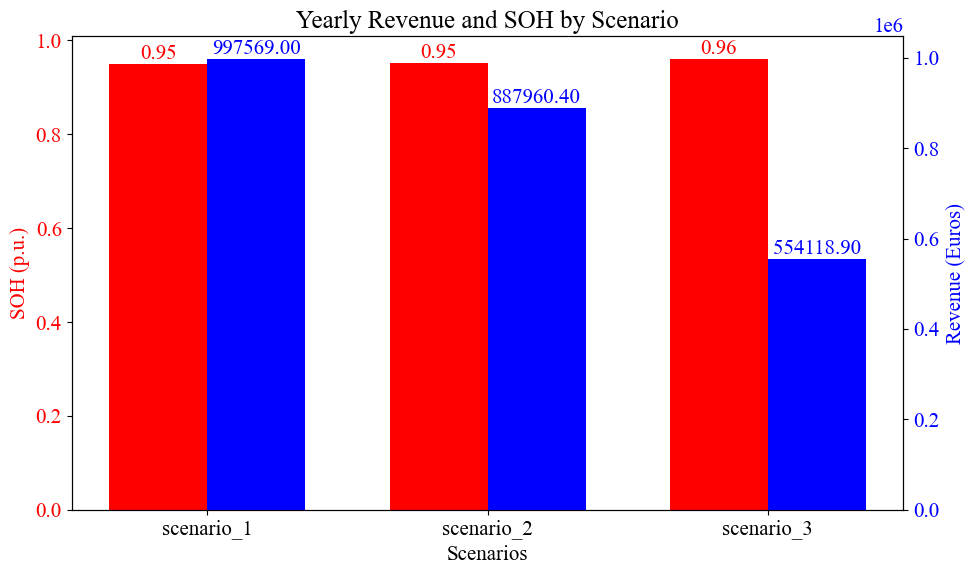

In [26]:
# SOH values extracted from previous calculations
soh_values = [soh_scenario_1, soh_scenario_2, soh_scenario_3]

# yearly revenues values extracted from previous calculations
revenues = [yearly_revenue_scenario_1, yearly_revenue_scenario_2, yearly_revenue_scenario_3]

# Scenario labels
scenarios = ['scenario_1', 'scenario_2', 'scenario_3']

# Set the font to Times New Roman and adjust the tick size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

# Create a bar chart with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35  # Width of the bars
index = np.arange(len(scenarios))  # The label locations

# Plot SOH bars on the left y-axis
bars1 = ax1.bar(index - bar_width/2, soh_values, bar_width, label='SOH (p.u.)', color='red')
ax1.set_xlabel('Scenarios')
ax1.set_ylabel('SOH (p.u.)', color='red')
ax1.tick_params(axis='y', labelcolor='red', labelsize=15)

# Create a second y-axis for revenue
ax2 = ax1.twinx()
bars2 = ax2.bar(index + bar_width/2, revenues, bar_width, label='Revenue (Euros)', color='blue')
ax2.set_ylabel('Revenue (Euros)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=15)

# Set the x-axis labels
ax1.set_xticks(index)
ax1.set_xticklabels(scenarios)
ax1.tick_params(axis='x', labelsize=15)

# Add values on top of the bars for clarity
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', color='red')

for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', color='blue')

# Title and layout adjustments
plt.title('Yearly Revenue and SOH by Scenario', fontsize=18)
fig.tight_layout()  # Adjust the layout to make room for the labels

# Show the plot
plt.show()